In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
import keras.optimizers

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터 준비

## Train dataset

In [2]:
# 데이터 load
raw_train= pd.read_csv('./data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
raw_train.head(25)

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
5,2013-01-01,6,A,2390.961
6,2013-01-01,7,A,2378.457
7,2013-01-01,8,A,2518.921
8,2013-01-01,9,A,2706.481
9,2013-01-01,10,A,2832.057


In [3]:
# 데이터 자료형 전처리
# 구분 확인
raw_train['구분'].unique()

# string object -> datetime 
raw_train['연월일'] = pd.to_datetime(raw_train['연월일'], format = '%Y-%m-%d')

# datetime + 시간 
## 시간 int -> flaot (datetime 더하기 할려면 필요)
raw_train = raw_train.astype({'시간':'float64'})
raw_train['연월일시'] = [raw_train['연월일'][i]+ timedelta(hours = raw_train['시간'][i]-1) for i in range(len(raw_train))]
#print(raw_df.head())

'''
# 연월일시 나눠서 컬럼 생성
raw_df['year'] = [raw_df['연월일시'][i].year for i in range(len(raw_df))]
raw_df['month'] = [raw_df['연월일시'][i].month for i in range(len(raw_df))]
raw_df['day'] = [raw_df['연월일시'][i].day for i in range(len(raw_df))]
raw_df['hour'] = [raw_df['연월일시'][i].hour for i in range(len(raw_df))]
#print(raw_df.tail())
'''
raw_train

,연월일,시간,구분,공급량,연월일시
0,2013-01-01,1.0,A,2497.129,2013-01-01 00:00:00
1,2013-01-01,2.0,A,2363.265,2013-01-01 01:00:00
2,2013-01-01,3.0,A,2258.505,2013-01-01 02:00:00
3,2013-01-01,4.0,A,2243.969,2013-01-01 03:00:00
4,2013-01-01,5.0,A,2344.105,2013-01-01 04:00:00
...,...,...,...,...,...
368083,2018-12-31,20.0,H,681.033,2018-12-31 19:00:00
368084,2018-12-31,21.0,H,669.961,2018-12-31 20:00:00
368085,2018-12-31,22.0,H,657.941,2018-12-31 21:00:00
368086,2018-12-31,23.0,H,610.953,2018-12-31 22:00:00


In [4]:
df = raw_train.set_index(raw_train['연월일시']).loc[:, ['구분', '공급량']]
df

,구분,공급량
연월일시,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2018-12-31 19:00:00,H,681.033
2018-12-31 20:00:00,H,669.961
2018-12-31 21:00:00,H,657.941


## Test dataset

In [5]:
# test 데이터 load
raw_test = pd.read_csv('./data/test.csv')
raw_test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [6]:
# 일자, 시간, 구분 분리
raw_test['일자'] = raw_test['일자|시간|구분'].str.split(' ').str[0]
raw_test['시간'] = raw_test['일자|시간|구분'].str.split(' ').str[1].astype(int)
raw_test['구분'] = raw_test['일자|시간|구분'].str.split(' ').str[2]
raw_test

# 원래 column 제거
raw_test.drop(columns='일자|시간|구분', inplace=True)
raw_test

,일자,시간,구분
0,2019-01-01,1,A
1,2019-01-01,2,A
2,2019-01-01,3,A
3,2019-01-01,4,A
4,2019-01-01,5,A
...,...,...,...
15115,2019-03-31,20,H
15116,2019-03-31,21,H
15117,2019-03-31,22,H
15118,2019-03-31,23,H


In [7]:
# string object -> datetime 
raw_test['일자'] = pd.to_datetime(raw_test['일자'], format = '%Y-%m-%d')

# datetime + 시간 
## 시간 int -> flaot (datetime 더하기 할려면 필요)
raw_test = raw_test.astype({'시간':'float64'})
raw_test['일자'] = [raw_test['일자'][i]+ timedelta(hours = raw_test['시간'][i]-1) for i in range(len(raw_test))]

raw_test.head(25)

,일자,시간,구분
0,2019-01-01 00:00:00,1.0,A
1,2019-01-01 01:00:00,2.0,A
2,2019-01-01 02:00:00,3.0,A
3,2019-01-01 03:00:00,4.0,A
4,2019-01-01 04:00:00,5.0,A
5,2019-01-01 05:00:00,6.0,A
6,2019-01-01 06:00:00,7.0,A
7,2019-01-01 07:00:00,8.0,A
8,2019-01-01 08:00:00,9.0,A
9,2019-01-01 09:00:00,10.0,A


In [8]:
# 시점 데이터 index로 변경
test= raw_test.set_index(raw_test['일자'])

# 컬럼 선택 및 y 생성
test['공급량'] = pd.Series()
test = test.loc[:, ['구분', '공급량']]
test

,구분,공급량
일자,,
2019-01-01 00:00:00,A,NaN
2019-01-01 01:00:00,A,NaN
2019-01-01 02:00:00,A,NaN
2019-01-01 03:00:00,A,NaN
2019-01-01 04:00:00,A,NaN
...,...,...
2019-03-31 19:00:00,H,NaN
2019-03-31 20:00:00,H,NaN
2019-03-31 21:00:00,H,NaN


## Sampling 구분=D 

## train sampling

In [9]:
train_D = df.query("구분 == 'D'").loc[:, '공급량']
train_D

연월일시
2013-01-01 00:00:00    1434.516
2013-01-01 01:00:00    1345.636
2013-01-01 02:00:00    1270.756
2013-01-01 03:00:00    1322.036
2013-01-01 04:00:00    1421.956
                         ...   
2018-12-31 19:00:00    1835.411
2018-12-31 20:00:00    1767.964
2018-12-31 21:00:00    1720.595
2018-12-31 22:00:00    1624.138
2018-12-31 23:00:00    1422.478
Name: 공급량, Length: 52584, dtype: float64

In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# define input sequence
raw_seq = train_D
# choose a number of time steps
n_steps_in, n_steps_out = 24, 1
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps_in, n_steps_out)
# summarize the data
'''for i in range(len(X)):
	print(X[i], y[i])'''

'for i in range(len(X)):\n\tprint(X[i], y[i])'

In [11]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (1, 2))
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)

In [12]:
X_train = np.reshape(X_train,(len(y_train), n_steps_in, -1))
print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)

X_train shape =  (52560, 24, 1)
y_train shape =  (52560, 1)


## Test sampling

In [13]:
test_D = test.query("구분 == 'D'").loc[:, '공급량']
test_D

일자
2019-01-01 00:00:00   NaN
2019-01-01 01:00:00   NaN
2019-01-01 02:00:00   NaN
2019-01-01 03:00:00   NaN
2019-01-01 04:00:00   NaN
                       ..
2019-03-31 19:00:00   NaN
2019-03-31 20:00:00   NaN
2019-03-31 21:00:00   NaN
2019-03-31 22:00:00   NaN
2019-03-31 23:00:00   NaN
Name: 공급량, Length: 2160, dtype: float64

In [14]:
test_D_df = pd.DataFrame(train_D[-24:], columns = ['공급량'])
test_D_df = test_D_df.append(pd.DataFrame(test_D, columns = ['공급량']))

In [15]:
test_D_df

,공급량
2018-12-31 00:00:00,1408.316
2018-12-31 01:00:00,1287.426
2018-12-31 02:00:00,1241.804
2018-12-31 03:00:00,1306.768
2018-12-31 04:00:00,1405.614
...,...
2019-03-31 19:00:00,NaN
2019-03-31 20:00:00,NaN
2019-03-31 21:00:00,NaN
2019-03-31 22:00:00,NaN


In [16]:
test1 = train_D[-24:]
test1 = np.array(test1).reshape(-1, 1)
test1 = scaler.fit_transform(test1)
test1 = test1.reshape(1, 24, 1)
test1.shape

(1, 24, 1)

## Modeling

In [17]:
# model custom loss, metric function 생성
def loss_nmae(true, pred):
    score = tf.reduce_mean((tf.math.abs(true-pred))/true)
    
    return score

In [18]:
#LSTM 모델 학습 original 

# model building 
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

# model compile 
adam = tf.keras.optimizers.Adam(lr = 0.001)
lstm_model.compile(optimizer=adam,loss=loss_nmae, metrics = 'mae')

# model fit
lstm_fit = lstm_model.fit(X_train, y_train, epochs=10, batch_size=100, validation_split = 0.1)
'''
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test,lstm_predictions)

lstm_model.summary()

print("R2 Score of LSTM model = ",lstm_score)
'''

Epoch 1/10
474/474 [==============================] - 14s 24ms/step - loss: 0.0905 - mae: 0.1163 - val_loss: 0.0522 - val_mae: 0.0622
Epoch 2/10
474/474 [==============================] - 11s 23ms/step - loss: 0.0704 - mae: 0.0907 - val_loss: 0.0495 - val_mae: 0.0618
Epoch 3/10
474/474 [==============================] - 11s 23ms/step - loss: 0.0666 - mae: 0.0859 - val_loss: 0.0445 - val_mae: 0.0545
Epoch 4/10
474/474 [==============================] - 11s 23ms/step - loss: 0.0620 - mae: 0.0803 - val_loss: 0.0540 - val_mae: 0.0683
Epoch 5/10
474/474 [==============================] - 11s 23ms/step - loss: 0.0578 - mae: 0.0750 - val_loss: 0.0432 - val_mae: 0.0522
Epoch 6/10
474/474 [==============================] - 11s 23ms/step - loss: 0.0494 - mae: 0.0639 - val_loss: 0.0248 - val_mae: 0.0313
Epoch 7/10
474/474 [==============================] - 11s 23ms/step - loss: 0.0405 - mae: 0.0525 - val_loss: 0.0174 - val_mae: 0.0215
Epoch 8/10
474/474 [==============================] - 11s 24ms

'\nlstm_predictions = lstm_model.predict(X_test)\n\nlstm_score = r2_score(y_test,lstm_predictions)\n\nlstm_model.summary()\n\nprint("R2 Score of LSTM model = ",lstm_score)\n'

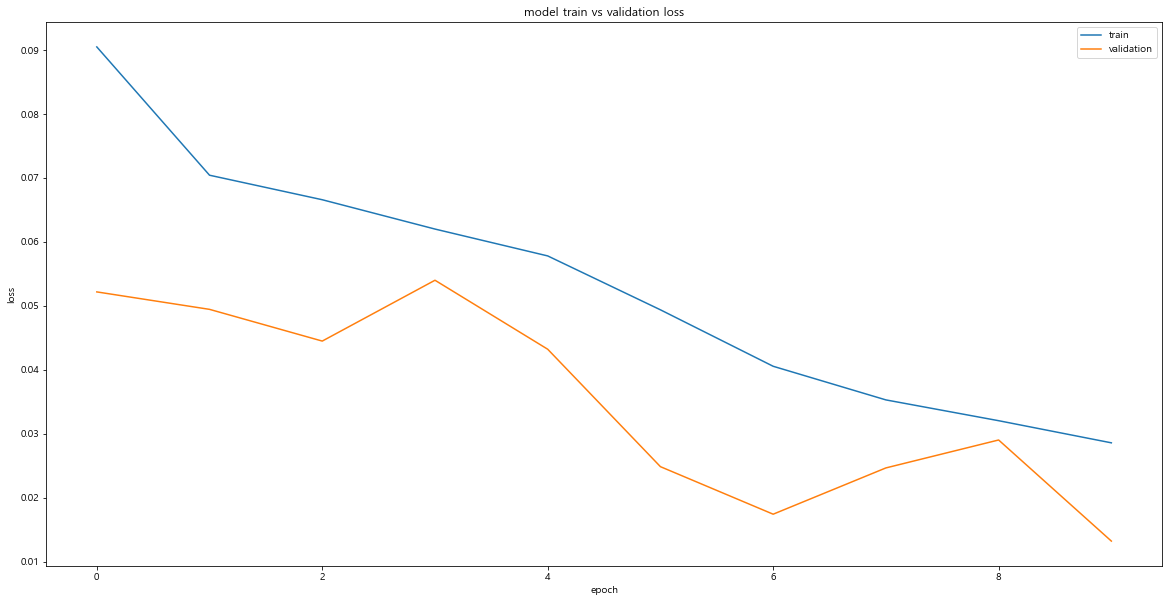

In [19]:
plt.figure(figsize = (20, 10))
plt.plot(lstm_fit.history['loss'])
plt.plot(lstm_fit.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Prediction

### test sampling

In [20]:
test_D = test.query("구분 == 'D'").loc[:, '공급량']
test_D

일자
2019-01-01 00:00:00   NaN
2019-01-01 01:00:00   NaN
2019-01-01 02:00:00   NaN
2019-01-01 03:00:00   NaN
2019-01-01 04:00:00   NaN
                       ..
2019-03-31 19:00:00   NaN
2019-03-31 20:00:00   NaN
2019-03-31 21:00:00   NaN
2019-03-31 22:00:00   NaN
2019-03-31 23:00:00   NaN
Name: 공급량, Length: 2160, dtype: float64

In [21]:
test_D_df = pd.DataFrame(train_D[-24:], columns = ['공급량'])
test_D_df = test_D_df.append(pd.DataFrame(test_D, columns = ['공급량']))
test_D_df

,공급량
2018-12-31 00:00:00,1408.316
2018-12-31 01:00:00,1287.426
2018-12-31 02:00:00,1241.804
2018-12-31 03:00:00,1306.768
2018-12-31 04:00:00,1405.614
...,...
2019-03-31 19:00:00,NaN
2019-03-31 20:00:00,NaN
2019-03-31 21:00:00,NaN
2019-03-31 22:00:00,NaN


In [22]:
test1 = train_D[-24:]
test1 = np.array(test1).reshape(-1, 1)
test1 = scaler.fit_transform(test1)
test1 = test1.reshape(1, 24, 1)
test1.shape

(1, 24, 1)

In [23]:
i=0
while test1.size <= 2160:
    i+=1
    pred = lstm_model.predict(test1[-24:].reshape(1, 24, 1))[0][0]
    test1 = np.append(test1, pred)
    print(f"{i}번째 예측 값 = {pred}")

test1.shape

1번째 예측 값 = 1.2499680519104004
2번째 예측 값 = 1.14703369140625
3번째 예측 값 = 1.0977658033370972
4번째 예측 값 = 1.129539966583252
5번째 예측 값 = 1.257130742073059
6번째 예측 값 = 1.4513366222381592
7번째 예측 값 = 1.6462905406951904
8번째 예측 값 = 1.7711313962936401
9번째 예측 값 = 1.7919747829437256
10번째 예측 값 = 1.720173716545105
11번째 예측 값 = 1.5943641662597656
12번째 예측 값 = 1.4359726905822754
13번째 예측 값 = 1.3082122802734375
14번째 예측 값 = 1.2217170000076294
15번째 예측 값 = 1.1810377836227417
16번째 예측 값 = 1.2088215351104736
17번째 예측 값 = 1.331626296043396
18번째 예측 값 = 1.5159873962402344
19번째 예측 값 = 1.6837809085845947
20번째 예측 값 = 1.7664706707000732
21번째 예측 값 = 1.7571394443511963
22번째 예측 값 = 1.6797077655792236
23번째 예측 값 = 1.5406310558319092
24번째 예측 값 = 1.389406681060791
25번째 예측 값 = 1.2967771291732788
26번째 예측 값 = 1.2119646072387695
27번째 예측 값 = 1.1685529947280884
28번째 예측 값 = 1.1885318756103516
29번째 예측 값 = 1.2924526929855347
30번째 예측 값 = 1.4564208984375
31번째 예측 값 = 1.6144726276397705
32번째 예측 값 = 1.7108561992645264
33번째 예측 값 = 1.7259378433227

268번째 예측 값 = 1.1349271535873413
269번째 예측 값 = 1.1360478401184082
270번째 예측 값 = 1.1618225574493408
271번째 예측 값 = 1.2074205875396729
272번째 예측 값 = 1.2591252326965332
273번째 예측 값 = 1.2992054224014282
274번째 예측 값 = 1.315124273300171
275번째 예측 값 = 1.3044981956481934
276번째 예측 값 = 1.273173451423645
277번째 예측 값 = 1.2307790517807007
278번째 예측 값 = 1.1871521472930908
279번째 예측 값 = 1.150913119316101
280번째 예측 값 = 1.1295666694641113
281번째 예측 값 = 1.129098892211914
282번째 예측 값 = 1.1519973278045654
283번째 예측 값 = 1.194130301475525
284번째 예측 값 = 1.2430872917175293
285번째 예측 값 = 1.2822425365447998
286번째 예측 값 = 1.2991981506347656
287번째 예측 값 = 1.2909184694290161
288번째 예측 값 = 1.2624232769012451
289번째 예측 값 = 1.2226665019989014
290번째 예측 값 = 1.1810474395751953
291번째 예측 값 = 1.1459051370620728
292번째 예측 값 = 1.124493956565857
293번째 예측 값 = 1.1226086616516113
294번째 예측 값 = 1.1427981853485107
295번째 예측 값 = 1.1815528869628906
296번째 예측 값 = 1.2276877164840698
297번째 예측 값 = 1.2657084465026855
298번째 예측 값 = 1.283468246459961
299번째 예측 값 = 1.

530번째 예측 값 = 1.0595638751983643
531번째 예측 값 = 1.0543818473815918
532번째 예측 값 = 1.0494974851608276
533번째 예측 값 = 1.046029806137085
534번째 예측 값 = 1.0447508096694946
535번째 예측 값 = 1.0458922386169434
536번째 예측 값 = 1.0490492582321167
537번째 예측 값 = 1.053253173828125
538번째 예측 값 = 1.0572412014007568
539번째 예측 값 = 1.059842586517334
540번째 예측 값 = 1.0603305101394653
541번째 예측 값 = 1.0586023330688477
542번째 예측 값 = 1.055140733718872
543번째 예측 값 = 1.0508238077163696
544번째 예측 값 = 1.0466816425323486
545번째 예측 값 = 1.0436656475067139
546번째 예측 값 = 1.042443037033081
547번째 예측 값 = 1.0432332754135132
548번째 예측 값 = 1.0457268953323364
549번째 예측 값 = 1.0491458177566528
550번째 예측 값 = 1.0524579286575317
551번째 예측 값 = 1.0546879768371582
552번째 예측 값 = 1.0552064180374146
553번째 예측 값 = 1.0538861751556396
554번째 예측 값 = 1.0510897636413574
555번째 예측 값 = 1.0475237369537354
556번째 예측 값 = 1.0440412759780884
557번째 예측 값 = 1.0414433479309082
558번째 예측 값 = 1.0403019189834595
559번째 예측 값 = 1.0408203601837158
560번째 예측 값 = 1.0427669286727905
561번째 예측 값 = 

792번째 예측 값 = 1.024538516998291
793번째 예측 값 = 1.024540901184082
794번째 예측 값 = 1.0245283842086792
795번째 예측 값 = 1.0245016813278198
796번째 예측 값 = 1.024465560913086
797번째 예측 값 = 1.0244264602661133
798번째 예측 값 = 1.024392008781433
799번째 예측 값 = 1.0243679285049438
800번째 예측 값 = 1.0243570804595947
801번째 예측 값 = 1.0243589878082275
802번째 예측 값 = 1.024369716644287
803번째 예측 값 = 1.024383544921875
804번째 예측 값 = 1.0243937969207764
805번째 예측 값 = 1.02439546585083
806번째 예측 값 = 1.0243855714797974
807번째 예측 값 = 1.0243648290634155
808번째 예측 값 = 1.024336338043213
809번째 예측 값 = 1.0243053436279297
810번째 예측 값 = 1.024277687072754
811번째 예측 값 = 1.0242578983306885
812번째 예측 값 = 1.0242482423782349
813번째 예측 값 = 1.024248719215393
814번째 예측 값 = 1.0242563486099243
815번째 예측 값 = 1.0242667198181152
816번째 예측 값 = 1.0242747068405151
817번째 예측 값 = 1.0242763757705688
818번째 예측 값 = 1.0242692232131958
819번째 예측 값 = 1.024253487586975
820번째 예측 값 = 1.0242316722869873
821번째 예측 값 = 1.0242074728012085
822번째 예측 값 = 1.0241851806640625
823번째 예측 값 = 1.02416

1049번째 예측 값 = 1.0237239599227905
1050번째 예측 값 = 1.0237236022949219
1051번째 예측 값 = 1.0237232446670532
1052번째 예측 값 = 1.0237230062484741
1053번째 예측 값 = 1.0237226486206055
1054번째 예측 값 = 1.0237224102020264
1055번째 예측 값 = 1.0237220525741577
1056번째 예측 값 = 1.0237218141555786
1057번째 예측 값 = 1.0237215757369995
1058번째 예측 값 = 1.0237212181091309
1059번째 예측 값 = 1.0237209796905518
1060번째 예측 값 = 1.023720622062683
1061번째 예측 값 = 1.0237202644348145
1062번째 예측 값 = 1.0237199068069458
1063번째 예측 값 = 1.0237195491790771
1064번째 예측 값 = 1.023719310760498
1065번째 예측 값 = 1.023719310760498
1066번째 예측 값 = 1.0237191915512085
1067번째 예측 값 = 1.023719310760498
1068번째 예측 값 = 1.023719310760498
1069번째 예측 값 = 1.023719310760498
1070번째 예측 값 = 1.0237194299697876
1071번째 예측 값 = 1.0237194299697876
1072번째 예측 값 = 1.023719310760498
1073번째 예측 값 = 1.023719310760498
1074번째 예측 값 = 1.023719072341919
1075번째 예측 값 = 1.0237189531326294
1076번째 예측 값 = 1.0237187147140503
1077번째 예측 값 = 1.0237184762954712
1078번째 예측 값 = 1.0237183570861816
1079번째 예측 값 = 1.023

1301번째 예측 값 = 1.0237094163894653
1302번째 예측 값 = 1.0237094163894653
1303번째 예측 값 = 1.0237094163894653
1304번째 예측 값 = 1.0237094163894653
1305번째 예측 값 = 1.0237094163894653
1306번째 예측 값 = 1.0237092971801758
1307번째 예측 값 = 1.0237092971801758
1308번째 예측 값 = 1.0237092971801758
1309번째 예측 값 = 1.0237092971801758
1310번째 예측 값 = 1.0237091779708862
1311번째 예측 값 = 1.0237090587615967
1312번째 예측 값 = 1.0237090587615967
1313번째 예측 값 = 1.0237089395523071
1314번째 예측 값 = 1.0237089395523071
1315번째 예측 값 = 1.0237089395523071
1316번째 예측 값 = 1.0237088203430176
1317번째 예측 값 = 1.0237088203430176
1318번째 예측 값 = 1.0237088203430176
1319번째 예측 값 = 1.0237089395523071
1320번째 예측 값 = 1.0237089395523071
1321번째 예측 값 = 1.0237090587615967
1322번째 예측 값 = 1.0237090587615967
1323번째 예측 값 = 1.0237090587615967
1324번째 예측 값 = 1.0237091779708862
1325번째 예측 값 = 1.0237091779708862
1326번째 예측 값 = 1.0237091779708862
1327번째 예측 값 = 1.0237092971801758
1328번째 예측 값 = 1.0237092971801758
1329번째 예측 값 = 1.0237092971801758
1330번째 예측 값 = 1.0237092971801758
1331번째 예측 

1554번째 예측 값 = 1.0237088203430176
1555번째 예측 값 = 1.0237088203430176
1556번째 예측 값 = 1.0237089395523071
1557번째 예측 값 = 1.0237089395523071
1558번째 예측 값 = 1.0237090587615967
1559번째 예측 값 = 1.0237090587615967
1560번째 예측 값 = 1.0237090587615967
1561번째 예측 값 = 1.0237091779708862
1562번째 예측 값 = 1.0237091779708862
1563번째 예측 값 = 1.0237092971801758
1564번째 예측 값 = 1.0237092971801758
1565번째 예측 값 = 1.0237091779708862
1566번째 예측 값 = 1.0237091779708862
1567번째 예측 값 = 1.0237091779708862
1568번째 예측 값 = 1.0237091779708862
1569번째 예측 값 = 1.0237090587615967
1570번째 예측 값 = 1.0237090587615967
1571번째 예측 값 = 1.0237089395523071
1572번째 예측 값 = 1.0237088203430176
1573번째 예측 값 = 1.0237088203430176
1574번째 예측 값 = 1.0237088203430176
1575번째 예측 값 = 1.023708701133728
1576번째 예측 값 = 1.023708701133728
1577번째 예측 값 = 1.023708701133728
1578번째 예측 값 = 1.023708701133728
1579번째 예측 값 = 1.0237088203430176
1580번째 예측 값 = 1.0237088203430176
1581번째 예측 값 = 1.0237088203430176
1582번째 예측 값 = 1.0237088203430176
1583번째 예측 값 = 1.0237089395523071
1584번째 예측 값 = 

1806번째 예측 값 = 1.0237083435058594
1807번째 예측 값 = 1.0237083435058594
1808번째 예측 값 = 1.023708462715149
1809번째 예측 값 = 1.0237085819244385
1810번째 예측 값 = 1.0237085819244385
1811번째 예측 값 = 1.0237088203430176
1812번째 예측 값 = 1.0237089395523071
1813번째 예측 값 = 1.0237090587615967
1814번째 예측 값 = 1.0237090587615967
1815번째 예측 값 = 1.0237091779708862
1816번째 예측 값 = 1.0237092971801758
1817번째 예측 값 = 1.0237092971801758
1818번째 예측 값 = 1.0237092971801758
1819번째 예측 값 = 1.0237092971801758
1820번째 예측 값 = 1.0237092971801758
1821번째 예측 값 = 1.0237091779708862
1822번째 예측 값 = 1.0237091779708862
1823번째 예측 값 = 1.0237090587615967
1824번째 예측 값 = 1.0237089395523071
1825번째 예측 값 = 1.023708701133728
1826번째 예측 값 = 1.0237085819244385
1827번째 예측 값 = 1.023708462715149
1828번째 예측 값 = 1.0237083435058594
1829번째 예측 값 = 1.0237083435058594
1830번째 예측 값 = 1.0237083435058594
1831번째 예측 값 = 1.0237083435058594
1832번째 예측 값 = 1.023708462715149
1833번째 예측 값 = 1.023708462715149
1834번째 예측 값 = 1.0237085819244385
1835번째 예측 값 = 1.0237085819244385
1836번째 예측 값 = 1

2059번째 예측 값 = 1.0237083435058594
2060번째 예측 값 = 1.023708462715149
2061번째 예측 값 = 1.0237085819244385
2062번째 예측 값 = 1.0237085819244385
2063번째 예측 값 = 1.0237088203430176
2064번째 예측 값 = 1.0237089395523071
2065번째 예측 값 = 1.0237090587615967
2066번째 예측 값 = 1.0237091779708862
2067번째 예측 값 = 1.0237092971801758
2068번째 예측 값 = 1.0237092971801758
2069번째 예측 값 = 1.0237094163894653
2070번째 예측 값 = 1.0237092971801758
2071번째 예측 값 = 1.0237092971801758
2072번째 예측 값 = 1.0237092971801758
2073번째 예측 값 = 1.0237091779708862
2074번째 예측 값 = 1.0237090587615967
2075번째 예측 값 = 1.0237090587615967
2076번째 예측 값 = 1.0237088203430176
2077번째 예측 값 = 1.023708701133728
2078번째 예측 값 = 1.0237085819244385
2079번째 예측 값 = 1.023708462715149
2080번째 예측 값 = 1.0237083435058594
2081번째 예측 값 = 1.0237083435058594
2082번째 예측 값 = 1.0237083435058594
2083번째 예측 값 = 1.0237083435058594
2084번째 예측 값 = 1.0237083435058594
2085번째 예측 값 = 1.0237083435058594
2086번째 예측 값 = 1.0237085819244385
2087번째 예측 값 = 1.0237085819244385
2088번째 예측 값 = 1.0237088203430176
2089번째 예측 값 =

(2161,)

In [24]:
test1

array([1.23836805, 1.06530957, 1.        , ..., 1.02370834, 1.02370846,
       1.02370858])

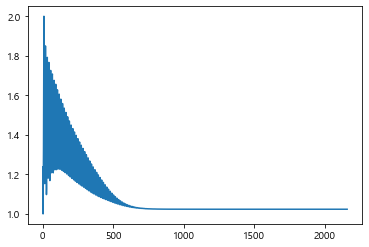

In [25]:
plt.plot(test1)